# Amazon Reviews Classifier

The goal of this project is to perform Aspect-Based Sentimento Analysis (ASBA) to dive into reviews and analyze the opinions of customers about a product. The project is divided into two parts: the first one is the data preprocessing, where we clean the data and extract the aspects and the second one is the classification, where we use the extracted aspects to classify the reviews.

## Initial Setup

### Install and import required packages

In [1]:
# Uncomment and run the following line if this is your first time running this notebook and you need to install the required packages
#!pip install -r "./requirements.txt"

import os
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contractions
import warnings
import time
import re
import spacy
import nltk
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from langdetect import detect, detect_langs
from tqdm import tqdm
from textblob import TextBlob
#from collections import Counter

# Initiate tdqm
tqdm.pandas()

### User Definitions

In [2]:
# Dataset: name of the dataset to be used (must be a CSV file inside /data folder)
dataset_name = "targeted_reviews.csv"

# Keywords to analyze for each aspect (edit only the keywords inside the list, not the list itself)
aspects = {
    "price": ["price", "cost", "value", "money", "cheap", "expensive", "affordable", "inexpensive", "reasonable", "fair", "reasonable", "worth"],
    "battery": ["battery", "battery life"],
    "performance": ["performance", "cpu", "ram", "processor", "gpu", "graphics"],
    "software": ["software", "operating system", "os", "programs"],
    "hardware": ["ports", "usb", "keyboard", "trackpad", "touchpad", "webcam", "cam"],
    "storage": ["storage", "hd", "hard drive", "ssd"],
    "audio": ["audio", "sound", "speakers"],
    "display": ["display", "screen", "resolution", "touchscreen"],
}

In [3]:
# Environment setup
pd.set_option("display.max_colwidth", None)

# Supress warnings
warnings.filterwarnings("ignore")

## Dataset Preprocessing

### Cleaning the dataset

In [4]:
raw_data = pd.read_csv('./data/' + dataset_name, encoding='utf-8')

raw_data.head(2)

,Unnamed: 0,product_name,review_title,review_body,review_author,review_rating,review_date,review_helpful_votes
0,0,"2020 Apple MacBook Air Laptop: Apple M1 Chip, 13” Retina Display, 8GB RAM, 256GB SSD Storage, Backlit Keyboard, FaceTime HD Camera, Touch ID. Works with iPhone/iPad; Gold",Display,The computer kept freezing up,Cynthia Bryant,2.0 out of 5 stars,"Reviewed in the United States on March 14, 2021",NaN
1,1,"2020 Apple MacBook Air Laptop: Apple M1 Chip, 13” Retina Display, 8GB RAM, 256GB SSD Storage, Backlit Keyboard, FaceTime HD Camera, Touch ID. Works with iPhone/iPad; Gold",Instant classic with magic battery,"The move to M1 has made this model an instant classic. If you like MacOS and need a daily driver person or light-load professional laptop, just buy it.",dee,5.0 out of 5 stars,"Reviewed in the United States on July 15, 2021",NaN


In [5]:
# Get only the relevant column
data = raw_data[["review_body"]].rename(columns={"review_body": "Review"})

# Shuffle the reviews
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,Review
0,Amazing quality. This laptop does NOT feel like an economy laptop from any angle. The features are amazing. Bought 2 on BF sale and am highly satisfied. Highly recommended!
1,Easy to use. Keys soft and responsive. Adequate size
2,The battery works just about 45minutes whit whit normal applications. Fans sounds like will blow op even whit the more silent profile. Search another option
3,i like the gold color!
4,Within a few weeks of using it my keypad got stuck in the corner. I have to regularly bend the laptop to unstick it. Not worth the $600 as much as it is very convenient to use for daily web surfing. Don't think I'll be buying an ASUS or chromebook again. I miss being able to download software....


In [6]:
# Remove rows with empty reviews
data = data[data["Review"].notna()]

# Remove extra spaces
data["Review"] = data["Review"].str.replace('\s+', ' ')

# Remove leading and trailing spaces
data["Review"] = data["Review"].str.strip()

# Remove reviews with less than 10 words
data = data[data["Review"].str.split().str.len() > 10]

# Set all reviews to lowercase
data["Review"] = data["Review"].str.lower()

# Print the number of reviews
print("Number of reviews before removing non-English reviews: " + str(len(data)))

# Remove non-English reviews using langdetect
def detect_language(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

data["Language"] = data["Review"].progress_apply(detect_language)
data = data[data["Language"] == "en"]
data = data.drop(columns=["Language"])

# Print the number of reviews after removing non-English reviews
print("Number of reviews after removing non-English reviews: " + str(len(data)))
# Reset the index
data = data.reset_index(drop=True)

data.head()

Number of reviews before removing non-English reviews: 22480


100%|██████████| 22480/22480 [02:32<00:00, 146.95it/s]

Number of reviews after removing non-English reviews: 21664


,Review
0,amazing quality. this laptop does not feel like an economy laptop from any angle. the features are amazing. bought 2 on bf sale and am highly satisfied. highly recommended!
1,the battery works just about 45minutes whit whit normal applications. fans sounds like will blow op even whit the more silent profile. search another option
2,within a few weeks of using it my keypad got stuck in the corner. i have to regularly bend the laptop to unstick it. not worth the $600 as much as it is very convenient to use for daily web surfing. don't think i'll be buying an asus or chromebook again. i miss being able to download software....
3,love being able to use either touch screen or key board. both screen quality & battery life are impressive. great purchase!
4,it was a gift for my kids 17th birthday. had been rocking with thick apple for a good minute. it has just brought them into the 22nd century... a great transition into college.


In [7]:
# Expand contractions
def expand_contractions(text):
    """
    Expand contractions (i.e don't -> do not)
    """
    expanded_text = contractions.fix(text, slang=False)
    return expanded_text

data['Review'] = data['Review'].apply(lambda x: expand_contractions(x))

In [8]:
preprocessed_data = data.copy()

nltk.download('punkt')

# get all sentences from the reviews that contains the specific keyswords of an aspect using nltk punkt
def get_sentences_with_keywords(review, keywords):
    """
    Get all sentences from the reviews that contains the specific keyswords of an aspect
    """
    sentences = ""
    tokens = nltk.sent_tokenize(review)
    for token in tokens:
        if any(word in token for word in keywords):
            # if it is the first sentence, just add it
            if sentences == "":
                sentences = token
            else:
                sentences += " | " + token
    
    return sentences

for aspect, keywords in aspects.items():
    preprocessed_data[aspect.capitalize() + " Sentences"] = preprocessed_data["Review"].progress_apply(lambda x: get_sentences_with_keywords(x, keywords))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 21664/21664 [00:03<00:00, 6446.18it/s]


In [9]:
preprocessed_data.head()

,Review,Price Sentences,Battery Sentences,Performance Sentences,Software Sentences,Hardware Sentences,Storage Sentences,Audio Sentences,Display Sentences
0,amazing quality. this laptop does not feel like an economy laptop from any angle. the features are amazing. bought 2 on bf sale and am highly satisfied. highly recommended!,,,,,,,,
1,the battery works just about 45minutes whit whit normal applications. fans sounds like will blow op even whit the more silent profile. search another option,,the battery works just about 45minutes whit whit normal applications.,,,,,fans sounds like will blow op even whit the more silent profile.,
2,within a few weeks of using it my keypad got stuck in the corner. i have to regularly bend the laptop to unstick it. not worth the $600 as much as it is very convenient to use for daily web surfing. do not think i will be buying an asus or chromebook again. i miss being able to download software....,not worth the $600 as much as it is very convenient to use for daily web surfing.,,,i miss being able to download software....,,,,
3,love being able to use either touch screen or key board. both screen quality & battery life are impressive. great purchase!,,both screen quality & battery life are impressive.,,,,,,love being able to use either touch screen or key board. | both screen quality & battery life are impressive.
4,it was a gift for my kids 17th birthday. had been rocking with thick apple for a good minute. it has just brought them into the 22nd century... a great transition into college.,,,,,,it was a gift for my kids 17th birthday.,,


In [10]:
# Remove emojis and symbols
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

for aspect, keywords in aspects.items():
    preprocessed_data[aspect[0].upper() + aspect[1:] + " Sentences"] = preprocessed_data[aspect[0].upper() + aspect[1:] + " Sentences"].apply(lambda x: remove_emojis(x))

preprocessed_data.head()

,Review,Price Sentences,Battery Sentences,Performance Sentences,Software Sentences,Hardware Sentences,Storage Sentences,Audio Sentences,Display Sentences
0,amazing quality. this laptop does not feel like an economy laptop from any angle. the features are amazing. bought 2 on bf sale and am highly satisfied. highly recommended!,,,,,,,,
1,the battery works just about 45minutes whit whit normal applications. fans sounds like will blow op even whit the more silent profile. search another option,,the battery works just about 45minutes whit whit normal applications.,,,,,fans sounds like will blow op even whit the more silent profile.,
2,within a few weeks of using it my keypad got stuck in the corner. i have to regularly bend the laptop to unstick it. not worth the $600 as much as it is very convenient to use for daily web surfing. do not think i will be buying an asus or chromebook again. i miss being able to download software....,not worth the $600 as much as it is very convenient to use for daily web surfing.,,,i miss being able to download software....,,,,
3,love being able to use either touch screen or key board. both screen quality & battery life are impressive. great purchase!,,both screen quality & battery life are impressive.,,,,,,love being able to use either touch screen or key board. | both screen quality & battery life are impressive.
4,it was a gift for my kids 17th birthday. had been rocking with thick apple for a good minute. it has just brought them into the 22nd century... a great transition into college.,,,,,,it was a gift for my kids 17th birthday.,,


### Labeling the Dataset

In [11]:
textblob_polarity = preprocessed_data.copy()

# Get the polarity of each sentence on the aspect sentences columns and add it to a new column positioned after the aspect sentences column
for aspect, keywords in aspects.items():
    textblob_polarity[aspect[0].upper() + aspect[1:] + " Polarity"] = textblob_polarity[aspect[0].upper() + aspect[1:] + " Sentences"].progress_apply(lambda x: ", ".join([str(TextBlob(sentence).sentiment.polarity) for sentence in x.split(" | ")]))

100%|██████████| 21664/21664 [00:06<00:00, 3427.58it/s]


In [12]:
# Reposition the columns to have the polarity columns right after the aspect sentences columns
textblob_polarity.head()

,Review,Price Sentences,Battery Sentences,Performance Sentences,Software Sentences,Hardware Sentences,Storage Sentences,Audio Sentences,Display Sentences,Price Polarity,Battery Polarity,Performance Polarity,Software Polarity,Hardware Polarity,Storage Polarity,Audio Polarity,Display Polarity
0,amazing quality. this laptop does not feel like an economy laptop from any angle. the features are amazing. bought 2 on bf sale and am highly satisfied. highly recommended!,,,,,,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,the battery works just about 45minutes whit whit normal applications. fans sounds like will blow op even whit the more silent profile. search another option,,the battery works just about 45minutes whit whit normal applications.,,,,,fans sounds like will blow op even whit the more silent profile.,,0.0,0.15,0.0,0.0,0.0,0.0,0.25,0.0
2,within a few weeks of using it my keypad got stuck in the corner. i have to regularly bend the laptop to unstick it. not worth the $600 as much as it is very convenient to use for daily web surfing. do not think i will be buying an asus or chromebook again. i miss being able to download software....,not worth the $600 as much as it is very convenient to use for daily web surfing.,,,i miss being able to download software....,,,,,0.016666666666666673,0.0,0.0,0.5,0.0,0.0,0.0,0.0
3,love being able to use either touch screen or key board. both screen quality & battery life are impressive. great purchase!,,both screen quality & battery life are impressive.,,,,,,love being able to use either touch screen or key board. | both screen quality & battery life are impressive.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"0.3333333333333333, 1.0"
4,it was a gift for my kids 17th birthday. had been rocking with thick apple for a good minute. it has just brought them into the 22nd century... a great transition into college.,,,,,,it was a gift for my kids 17th birthday.,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Make an avarage of the polarity of each aspect if there are more than one sentence for that aspect
for aspect, keywords in aspects.items():
    textblob_polarity[aspect[0].upper() + aspect[1:] + " Polarity"] = textblob_polarity[aspect[0].upper() + aspect[1:] + " Polarity"].progress_apply(lambda x: np.mean([float(polarity) for polarity in x.split(", ")])
    
    if len(x.split(", ")) > 1 else x)

100%|██████████| 21664/21664 [00:00<00:00, 475727.62it/s]


In [14]:
textblob_polarity.head()

,Review,Price Sentences,Battery Sentences,Performance Sentences,Software Sentences,Hardware Sentences,Storage Sentences,Audio Sentences,Display Sentences,Price Polarity,Battery Polarity,Performance Polarity,Software Polarity,Hardware Polarity,Storage Polarity,Audio Polarity,Display Polarity
0,amazing quality. this laptop does not feel like an economy laptop from any angle. the features are amazing. bought 2 on bf sale and am highly satisfied. highly recommended!,,,,,,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,the battery works just about 45minutes whit whit normal applications. fans sounds like will blow op even whit the more silent profile. search another option,,the battery works just about 45minutes whit whit normal applications.,,,,,fans sounds like will blow op even whit the more silent profile.,,0.0,0.15,0.0,0.0,0.0,0.0,0.25,0.0
2,within a few weeks of using it my keypad got stuck in the corner. i have to regularly bend the laptop to unstick it. not worth the $600 as much as it is very convenient to use for daily web surfing. do not think i will be buying an asus or chromebook again. i miss being able to download software....,not worth the $600 as much as it is very convenient to use for daily web surfing.,,,i miss being able to download software....,,,,,0.016666666666666673,0.0,0.0,0.5,0.0,0.0,0.0,0.0
3,love being able to use either touch screen or key board. both screen quality & battery life are impressive. great purchase!,,both screen quality & battery life are impressive.,,,,,,love being able to use either touch screen or key board. | both screen quality & battery life are impressive.,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667
4,it was a gift for my kids 17th birthday. had been rocking with thick apple for a good minute. it has just brought them into the 22nd century... a great transition into college.,,,,,,it was a gift for my kids 17th birthday.,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Change the polarity values to Negative, Neutral or Positive
def define_polarity(x):
    if float(x) == 0:
        return "Neutral"
    elif float(x) < 0:
        return "Negative"
    else:
        return "Positive"

for aspect, keywords in aspects.items():
    textblob_polarity[aspect[0].upper() + aspect[1:] + " Polarity"] = textblob_polarity[aspect[0].upper() + aspect[1:] + " Polarity"].progress_apply(lambda x: define_polarity(x))

100%|██████████| 21664/21664 [00:00<00:00, 121643.36it/s]


In [16]:
textblob_polarity.head(10)

,Review,Price Sentences,Battery Sentences,Performance Sentences,Software Sentences,Hardware Sentences,Storage Sentences,Audio Sentences,Display Sentences,Price Polarity,Battery Polarity,Performance Polarity,Software Polarity,Hardware Polarity,Storage Polarity,Audio Polarity,Display Polarity
0,amazing quality. this laptop does not feel like an economy laptop from any angle. the features are amazing. bought 2 on bf sale and am highly satisfied. highly recommended!,,,,,,,,,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
1,the battery works just about 45minutes whit whit normal applications. fans sounds like will blow op even whit the more silent profile. search another option,,the battery works just about 45minutes whit whit normal applications.,,,,,fans sounds like will blow op even whit the more silent profile.,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral,Positive,Neutral
2,within a few weeks of using it my keypad got stuck in the corner. i have to regularly bend the laptop to unstick it. not worth the $600 as much as it is very convenient to use for daily web surfing. do not think i will be buying an asus or chromebook again. i miss being able to download software....,not worth the $600 as much as it is very convenient to use for daily web surfing.,,,i miss being able to download software....,,,,,Positive,Neutral,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
3,love being able to use either touch screen or key board. both screen quality & battery life are impressive. great purchase!,,both screen quality & battery life are impressive.,,,,,,love being able to use either touch screen or key board. | both screen quality & battery life are impressive.,Neutral,Positive,Neutral,Neutral,Neutral,Neutral,Neutral,Positive
4,it was a gift for my kids 17th birthday. had been rocking with thick apple for a good minute. it has just brought them into the 22nd century... a great transition into college.,,,,,,it was a gift for my kids 17th birthday.,,,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
5,"great computer for gaming. not a computer expert but it handles what i play very well. just the battery life sucks but oh well, not like i carry it everywhere",,"just the battery life sucks but oh well, not like i carry it everywhere",,,,,,,Neutral,Negative,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
6,it is light weight and comfortable to use. plenty of room to rest your hand as typing yet a slim design.,,,,,,,,,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
7,"i have been looking for a laptop for sometime now - roughly 6 years. i am upgrading from an i5 hp desktop computer. its trash, but you know what is not trash? this awesome msi laptop!",,,,,,,,,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
8,"i would not game on it. i would do ok for things that are not gpu intensive. they underclocked the gpu so you do not get the full power out of it but i caught it on sale and it was the cheapest laptop that fit my specs. works great, great battery life and fantastic to work from home. only downside are the small compress chiclet keys, but its a laptop.",they underclocked the gpu so you do not get the full power out of it but i caught it on sale and it was the cheapest laptop that fit my specs.,"works great, great battery life and fantastic to work from home.",i would do ok for things that are not gpu intensive. | they underclocked the gpu so you do not get the full power out of it but i caught it on sale and it was the cheapest laptop that fit my specs.,,,,,,Positive,Positive,Positive,Neutral,Neutral,Neutral,Neutral,Neutral
9,does anyone notice how low the volume is on this laptop? i love everything about the product except i cannot hardly hear anything on it even when the volume is on max.,,,,,,,,,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral


In [76]:
# Create a dataframe to store the results
results = pd.DataFrame(columns=["Aspect", "Polarity", "Count"])

# Get the count of each polarity for each aspect
for aspect, keywords in aspects.items():
    polarity_count = textblob_polarity[aspect[0].upper() + aspect[1:] + " Polarity"].value_counts().reset_index()
    polarity_count.columns = ["Polarity", "Count"]
    polarity_count["Aspect"] = aspect
    results = pd.concat([results, polarity_count], axis=0)

results = results.reset_index(drop=True)

results

,Aspect,Polarity,Count
0,price,Neutral,15812
1,price,Positive,5037
2,price,Negative,815
3,battery,Neutral,19712
4,battery,Positive,1505
5,battery,Negative,447
6,performance,Neutral,18490
7,performance,Positive,2645
8,performance,Negative,529
9,software,Neutral,16804


In [18]:
# Defining the datasets for each aspect
price_data = textblob_polarity.copy()[["Price Sentences", "Price Polarity"]]
price_data = price_data[price_data["Price Sentences"] != ""]
price_data = price_data.reset_index(drop=True)
battery_data = textblob_polarity.copy()[["Battery Sentences", "Battery Polarity"]]
battery_data = battery_data[battery_data["Battery Sentences"] != ""]
battery_data = battery_data.reset_index(drop=True)
performance_data = textblob_polarity.copy()[["Performance Sentences", "Performance Polarity"]]
performance_data = performance_data[performance_data["Performance Sentences"] != ""]
performance_data = performance_data.reset_index(drop=True)
software_data = textblob_polarity.copy()[["Software Sentences", "Software Polarity"]]
software_data = software_data[software_data["Software Sentences"] != ""]
software_data = software_data.reset_index(drop=True)
hardware_data = textblob_polarity.copy()[["Hardware Sentences", "Hardware Polarity"]]
hardware_data = hardware_data[hardware_data["Hardware Sentences"] != ""]
hardware_data = hardware_data.reset_index(drop=True)
storage_data = textblob_polarity.copy()[["Storage Sentences", "Storage Polarity"]]
storage_data = storage_data[storage_data["Storage Sentences"] != ""]
storage_data = storage_data.reset_index(drop=True)
audio_data = textblob_polarity.copy()[["Audio Sentences", "Audio Polarity"]]
audio_data = audio_data[audio_data["Audio Sentences"] != ""]
audio_data = audio_data.reset_index(drop=True)
display_data = textblob_polarity.copy()[["Display Sentences", "Display Polarity"]]
display_data = display_data[display_data["Display Sentences"] != ""]
display_data = display_data.reset_index(drop=True)

In [19]:
# Delete any files that may be on the /data/preprocessed_data folder
for file in os.listdir("data/preprocessed_data"):
    os.remove(os.path.join("data/preprocessed_data", file))

# Save the preprocessed data to a csv files
price_data.to_csv("data/preprocessed_data/price_data.csv")
battery_data.to_csv("data/preprocessed_data/battery_data.csv")
performance_data.to_csv("data/preprocessed_data/performance_data.csv")
software_data.to_csv("data/preprocessed_data/software_data.csv")
hardware_data.to_csv("data/preprocessed_data/hardware_data.csv")
storage_data.to_csv("data/preprocessed_data/storage_data.csv")
audio_data.to_csv("data/preprocessed_data/audio_data.csv")
display_data.to_csv("data/preprocessed_data/display_data.csv")

## Training

### Defining global variables

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Defaults to 1000.

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.

- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.

- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".
    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8

In [20]:
NUM_WORDS = 2000
EMBEDDING_DIM = 16
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

### Defining the functions to preprocess and train the model

#### Loading and pre-processing the data

In [21]:
def remove_stopwords(sentence):
    """
    Removes stopwords from a sentence
    """
    # List of stopwords using the nltk library
    stop_words = set(stopwords.words('english'))
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_dataframe(dataframe, aspect):
    """
    Extracts sentences and labels from the dataframe 
    """
    sentences = []
    labels = []
    for index, row in dataframe.iterrows():
        sentences.append(row[aspect + " Sentences"])
        labels.append(row[aspect + " Polarity"])

    return sentences, labels

#### Training-Validation Split

In [22]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    """
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

#### Tokenization - Sequences and padding

In [23]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    """

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [24]:
def seq_and_pad(sentences, tokenizer, padding):
    """
    Generates an array of token sequences and pads them to the same length
    """    

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding
    padded_sequences = pad_sequences(sequences, padding=padding)
    
    return padded_sequences

In [25]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    """
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np

#### Creating the model for classification

In [26]:
def create_model(num_words, embedding_dim):
    """
    Creates a text classifier model
    """
    
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy']) 

    return model

In [27]:
# Callback to stop when training reaches 99% accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.99):
            print("Reached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [28]:
def train_model(dataframe, aspect):

    # Get the sentences and labels from the dataframe
    sentences, labels = parse_data_from_dataframe(dataframe, aspect.capitalize())

    # Split the data into training and validation sets
    train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

    # Fit the tokenizer on the training sentences
    tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
    word_index = tokenizer.word_index

    # Convert the sentences to sequences and pad them to the same length
    train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING)
    val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING)

    # Tokenize the labels
    train_label_seq = tokenize_labels(labels, train_labels)
    val_label_seq = tokenize_labels(labels, val_labels)

    model = create_model(NUM_WORDS, EMBEDDING_DIM)

    # Train the model
    history = model.fit(train_padded_seq, train_label_seq, epochs=100, validation_data=(val_padded_seq, val_label_seq), verbose=2, callbacks=[callbacks])

    return model, history

In [29]:
price_model, price_history = train_model(price_data, "price")
battery_model, battery_history = train_model(battery_data, "battery")
performace_model, performance_history = train_model(performance_data, "performance")
software_model, software_history = train_model(software_data, "software")
hardware_model, hardware_history = train_model(hardware_data, "hardware")
storage_model, storage_history = train_model(storage_data, "storage")
audio_model, audio_history = train_model(audio_data, "audio")
display_model, display_history = train_model(display_data, "display")

Epoch 1/100
162/162 - 2s - loss: 0.8037 - accuracy: 0.7766 - val_loss: 0.6647 - val_accuracy: 0.7867 - 2s/epoch - 14ms/step
Epoch 2/100
162/162 - 1s - loss: 0.6826 - accuracy: 0.7766 - val_loss: 0.6562 - val_accuracy: 0.7867 - 1s/epoch - 8ms/step
Epoch 3/100
162/162 - 1s - loss: 0.6783 - accuracy: 0.7766 - val_loss: 0.6519 - val_accuracy: 0.7867 - 1s/epoch - 6ms/step
Epoch 4/100
162/162 - 2s - loss: 0.6742 - accuracy: 0.7766 - val_loss: 0.6404 - val_accuracy: 0.7867 - 2s/epoch - 10ms/step
Epoch 5/100
162/162 - 1s - loss: 0.6666 - accuracy: 0.7766 - val_loss: 0.6275 - val_accuracy: 0.7867 - 1s/epoch - 6ms/step
Epoch 6/100
162/162 - 1s - loss: 0.6561 - accuracy: 0.7766 - val_loss: 0.6081 - val_accuracy: 0.7867 - 1s/epoch - 6ms/step
Epoch 7/100
162/162 - 1s - loss: 0.6400 - accuracy: 0.7766 - val_loss: 0.5837 - val_accuracy: 0.7867 - 953ms/epoch - 6ms/step
Epoch 8/100
162/162 - 1s - loss: 0.6187 - accuracy: 0.7766 - val_loss: 0.5564 - val_accuracy: 0.7867 - 1s/epoch - 8ms/step
Epoch 9/100

# Visualization

## Models Evaluation

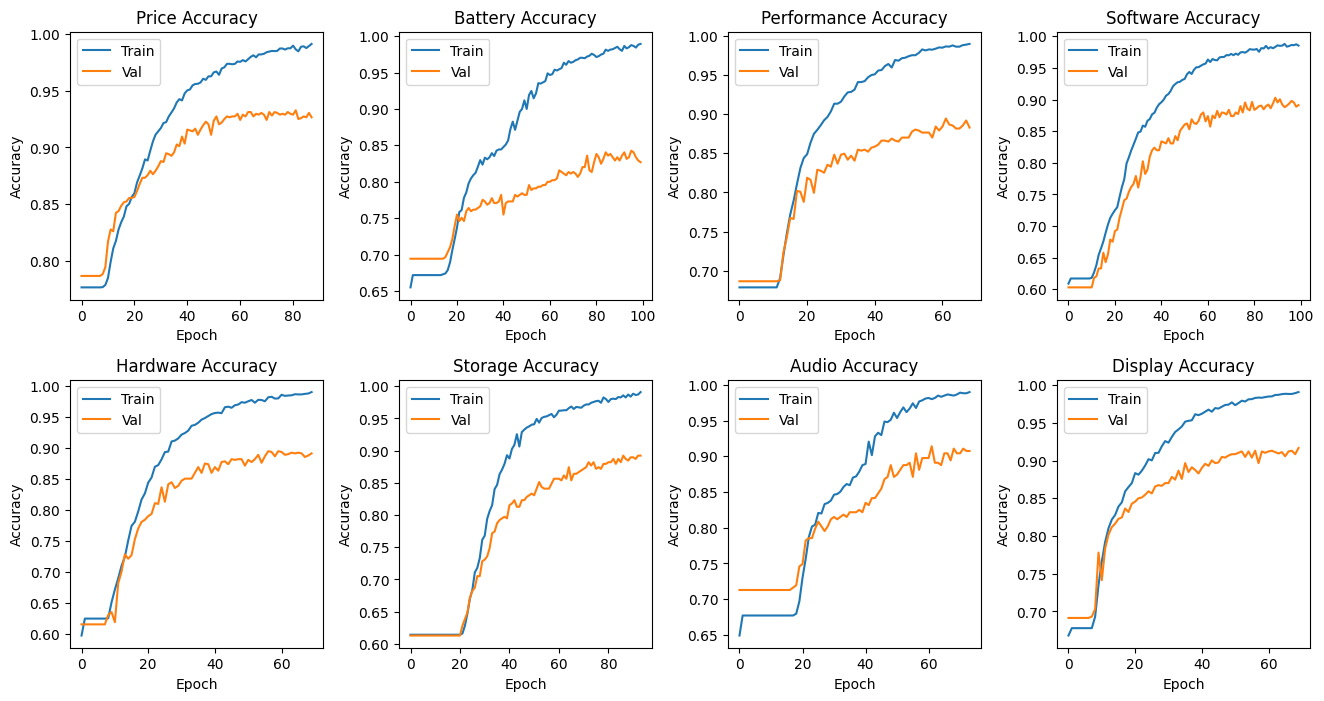

In [30]:
# Plot the training and validation accuracy for each aspect
plt.figure(figsize=(16, 8))
# add space between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 4, 1)
plt.plot(price_history.history['accuracy'])
plt.plot(price_history.history['val_accuracy'])
plt.title('Price Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 2)
plt.plot(battery_history.history['accuracy'])
plt.plot(battery_history.history['val_accuracy'])
plt.title('Battery Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 3)
plt.plot(performance_history.history['accuracy'])
plt.plot(performance_history.history['val_accuracy'])
plt.title('Performance Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 4)
plt.plot(software_history.history['accuracy'])
plt.plot(software_history.history['val_accuracy'])
plt.title('Software Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 5)
plt.plot(hardware_history.history['accuracy'])
plt.plot(hardware_history.history['val_accuracy'])
plt.title('Hardware Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 6)
plt.plot(storage_history.history['accuracy'])
plt.plot(storage_history.history['val_accuracy'])
plt.title('Storage Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 7)
plt.plot(audio_history.history['accuracy'])
plt.plot(audio_history.history['val_accuracy'])
plt.title('Audio Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 8)
plt.plot(display_history.history['accuracy'])
plt.plot(display_history.history['val_accuracy'])
plt.title('Display Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

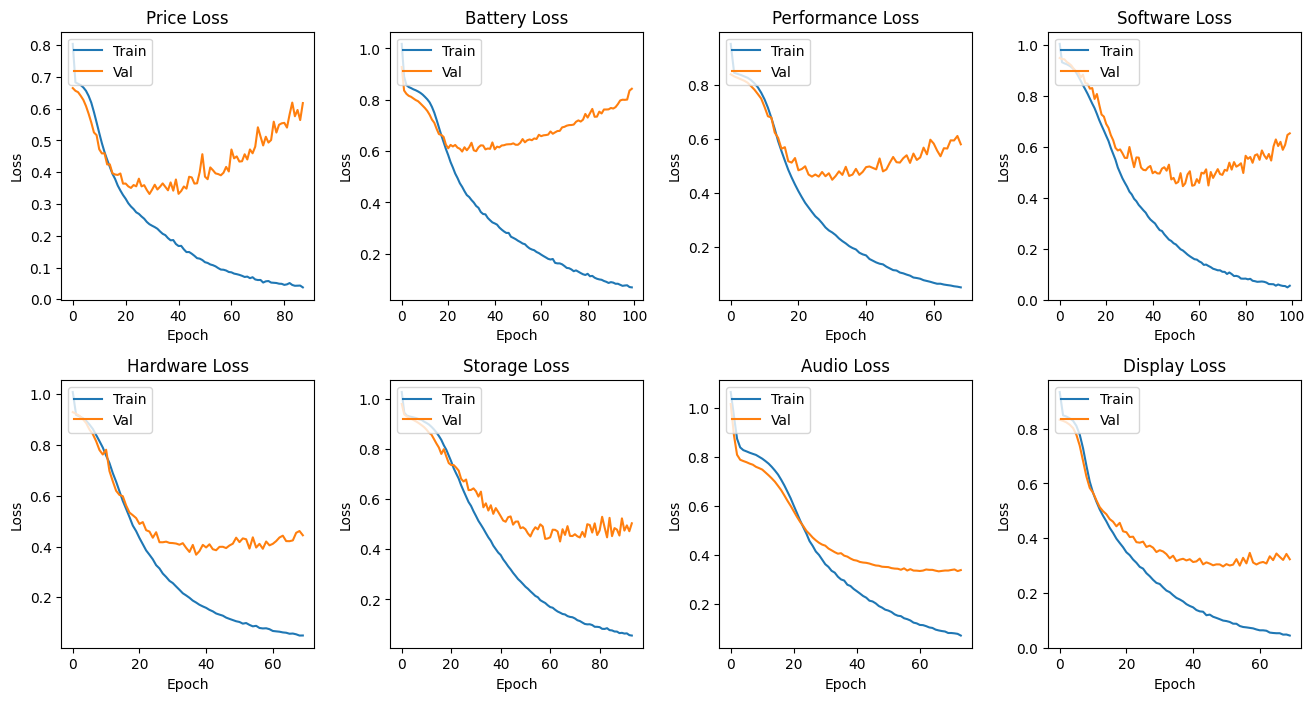

In [31]:
# Plot the training and validation loss for each aspect
plt.figure(figsize=(16, 8))
# add space between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(2, 4, 1)
plt.plot(price_history.history['loss'])
plt.plot(price_history.history['val_loss'])
plt.title('Price Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 2)
plt.plot(battery_history.history['loss'])
plt.plot(battery_history.history['val_loss'])
plt.title('Battery Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 3)
plt.plot(performance_history.history['loss'])
plt.plot(performance_history.history['val_loss'])
plt.title('Performance Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 4)
plt.plot(software_history.history['loss'])
plt.plot(software_history.history['val_loss'])
plt.title('Software Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 5)
plt.plot(hardware_history.history['loss'])
plt.plot(hardware_history.history['val_loss'])
plt.title('Hardware Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 6)
plt.plot(storage_history.history['loss'])
plt.plot(storage_history.history['val_loss'])
plt.title('Storage Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 7)
plt.plot(audio_history.history['loss'])
plt.plot(audio_history.history['val_loss'])
plt.title('Audio Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 4, 8)
plt.plot(display_history.history['loss'])
plt.plot(display_history.history['val_loss'])
plt.title('Display Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')